In [72]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from pyproj import Proj, transform
import contextily as ctx
from shapely.geometry import box
import fiona

# Documentation for how to use data here: https://www.pge.com/b2b/distribution-resource-planning/downloads/integration-capacity/PGE_ICA_Map_User_Guide.pdf
gdb_path = "../data/raw/ICADisplay.gdb"

# List all layers
layers = fiona.listlayers(gdb_path)
# [
# 'LineDetail',
# 'ICANotAvailable', 
# 'FeederDetail', 
# 'Substations', 
# 'FeederLoadProfile', 
# 'SubstationLoadProfile', 
# 'TransmissionLines', 
# 'networkedSecondaryBuffer', 
# 'FeederSubstationSummary', 
# 'ICAEstimatedCapacitySummary'
# ]

In [73]:
feeder = gpd.read_file("../data/raw/ICADisplay.gdb", driver='fileGDB', layer="FeederDetail")
feeder_load = gpd.read_file("../data/raw/ICADisplay.gdb", driver='fileGDB', layer="FeederLoadProfile")

In [74]:
# Print names of columns
dataframes = {
    'feeder': feeder,
    'feeder_load': feeder_load,
}

# Printing column keys in a table format
for name, df in dataframes.items():
    print(f"DataFrame: {name}")
    print(df.columns.tolist())
    print()

DataFrame: feeder
['Substation', 'FeederID', 'Feeder_Name', 'Nominal_Voltage', 'Load_Profile_Redaction', 'ResCust', 'ComCust', 'IndCust', 'AgrCust', 'OthCust', 'Existing_DG', 'Queued_DG', 'Total_DG', 'Show', 'VOLTNUM', 'Shape_Length', 'geometry']

DataFrame: feeder_load
['FeederID', 'MonthHour', 'Light', 'High', 'geometry']



In [75]:
feeder.head()

,Substation,FeederID,Feeder_Name,Nominal_Voltage,Load_Profile_Redaction,ResCust,ComCust,IndCust,AgrCust,OthCust,Existing_DG,Queued_DG,Total_DG,Show,VOLTNUM,Shape_Length,geometry
0,VACA DIXON,063591102,VACA DIXON 1102,12kV,Yes,1433,101,24,0,6,8280,5770,14050,1,12.00,26933.320905,"MULTILINESTRING ((592261.255 4250204.183, 5922..."
1,OAKLAND C,012011114,OAKLAND C 1114,12kV,No,2242,274,138,3,20,1320,590,1910,1,12.00,11458.048102,"MULTILINESTRING ((564225.965 4183386.053, 5642..."
2,SAUSALITO,042490402,SAUSALITO 0402,4.16kV,Yes,523,8,1,0,0,360,160,520,1,4.16,5054.876335,"MULTILINESTRING ((544321.595 4190204.063, 5443..."
3,BUENA VISTA,182261106,BUENA VISTA 1106,12kV,Yes,14,25,18,49,1,200,200,400,1,12.00,23941.399005,"MULTILINESTRING ((623924.545 4056135.993, 6239..."
4,RICE,062831101,RICE 1101,12kV,Yes,79,36,5,129,2,1140,1640,2780,1,12.00,87963.924972,"MULTILINESTRING ((592530.865 4372162.253, 5925..."


In [76]:
feeder_load.head()

,FeederID,MonthHour,Light,High,geometry
0,12022212,01_00,3449.0,3904,None
1,12041106,01_00,3098.0,3370,None
2,12060404,01_00,736.0,843,None
3,12061104,01_00,898.0,1430,None
4,12091101,01_00,2224.0,2662,None


In [77]:
# Ensure FeederID columns are of the same type
feeder['FeederID'] = feeder['FeederID'].astype(str)
feeder_load['FeederID'] = feeder_load['FeederID'].astype(str)

# Check for matches
matches = feeder_load[feeder_load['FeederID'].isin(feeder['FeederID'])]

# Check for unmatched entries
unmatched_load = feeder_load[~feeder_load['FeederID'].isin(feeder['FeederID'])]
unmatched_feeder = feeder[~feeder['FeederID'].isin(feeder_load['FeederID'])]

# Print results
print("Matches on FeederID:")
print(matches)
print()

print("Unmatched entries in feeder_load:")
print(unmatched_load)
print()

print("Unmatched entries in feeder:")
print(unmatched_feeder)
print()


Matches on FeederID:
         FeederID MonthHour   Light  High geometry
753     102041102     01_00  2066.0  2351     None
754     102041104     01_00  2093.0  2469     None
755     102551101     01_00  1783.0  2019     None
756     102650401     01_00   227.0   285     None
757     102741101     01_00   745.0   874     None
...           ...       ...     ...   ...      ...
582091  254702104     12_23   769.0  1062     None
582092  255121101     12_23  2060.0  2671     None
582093  255121102     12_23  2761.0  3143     None
582094  255262101     12_23  3561.0  3857     None
582095  255292109     12_23  3028.0  3517     None

[264384 rows x 5 columns]

Unmatched entries in feeder_load:
         FeederID MonthHour   Light  High geometry
0        12022212     01_00  3449.0  3904     None
1        12041106     01_00  3098.0  3370     None
2        12060404     01_00   736.0   843     None
3        12061104     01_00   898.0  1430     None
4        12091101     01_00  2224.0  2662     None

In [78]:
import pandas as pd

# Assuming feeder_load is your DataFrame with the 'FeederID' column
# Group by 'FeederID' and count the number of entries for each ID
feeder_id_counts = feeder_load.groupby('FeederID').size()

# Filter to find FeederIDs with more than one entry
duplicate_feeder_ids = feeder_id_counts[feeder_id_counts > 1]

# Print the results
print("FeederIDs with multiple entries:")
print(duplicate_feeder_ids)

FeederIDs with multiple entries:
FeederID
102041101    288
102041102    288
102041103    288
102041104    288
102050401    288
            ... 
83892107     288
83901101     288
83912109     288
83912110     288
83912111     288
Length: 2022, dtype: int64


In [229]:
import pandas as pd

# Assuming feeder_load and feeder are your DataFrames

# Group by 'FeederID' and count the number of entries for each ID
feeder_id_counts = feeder_load.groupby('FeederID').size()

# Filter to find FeederIDs with more than one entry
duplicate_feeder_ids = feeder_id_counts[feeder_id_counts > 1].index

# Print the results
print("FeederIDs with multiple entries:")
print(duplicate_feeder_ids)

# Filter the feeder DataFrame to include only rows with the duplicate FeederIDs
feeder_duplicates = feeder[feeder['FeederID'].isin(duplicate_feeder_ids)]

# Merge the geometry from feeder to feeder_load based on FeederID
feeder_load_with_geometry = feeder_load.merge(feeder_duplicates[['FeederID', 'geometry']], on='FeederID', how='left')

# Now filter the merged DataFrame to get only the rows with duplicate FeederIDs
duplicate_feeder_data_with_geometry = feeder_load_with_geometry[feeder_load_with_geometry['FeederID'].isin(duplicate_feeder_ids)]

# Take a sample of the data (adjust the sample size as needed)
sample_size = 20  # Adjust the sample size to your requirement
sample_data = duplicate_feeder_data_with_geometry.sample(n=sample_size, random_state=42)

# Print the sample data
print("Sample of duplicate FeederID data with geometry:")
print(sample_data)


FeederIDs with multiple entries:
Index(['102041101', '102041102', '102041103', '102041104', '102050401',
       '102050402', '102051102', '102051103', '102111101', '102121102',
       ...
       '83871105', '83871108', '83892102', '83892104', '83892106', '83892107',
       '83901101', '83912109', '83912110', '83912111'],
      dtype='object', name='FeederID', length=2022)
Sample of duplicate FeederID data with geometry:
         FeederID MonthHour   Light  High  \
42937   253142101     02_03   148.0   435   
156624   13652114     05_06  3278.0  3830   
184927  162771105     06_00  2224.0  4398   
495076  255121101     05_19  2442.0  5524   
437068  255322103     01_00  2090.0  2502   
514501   62061102     07_10   116.0  1426   
409617  182611107     12_14  1517.0  3459   
119039   62041109     04_08  3353.0  3933   
407060   14381104     12_13  4409.0  5430   
146079   43301105     04_21  4534.0  4863   
559926   24181103     11_04  3154.0  3398   
82332   254072105     03_06  3700.0 

FeederID     288
MonthHour    288
Light        288
High         288
dtype: int64
FeederID     288
MonthHour    288
Light        288
High         288
dtype: int64
FeederID     288
MonthHour    288
Light        288
High         288
dtype: int64
FeederID     288
MonthHour    288
Light        288
High         288
dtype: int64
FeederID     288
MonthHour    288
Light        288
High         288
dtype: int64
FeederID     288
MonthHour    288
Light        288
High         288
dtype: int64
FeederID     288
MonthHour    288
Light        288
High         288
dtype: int64
FeederID     288
MonthHour    288
Light        288
High         288
dtype: int64
FeederID     288
MonthHour    288
Light        288
High         288
dtype: int64
FeederID     288
MonthHour    288
Light        288
High         288
dtype: int64
FeederID     288
MonthHour    288
Light        288
High         288
dtype: int64
FeederID     288
MonthHour    288
Light        288
High         288
dtype: int64
FeederID     288
MonthHour  

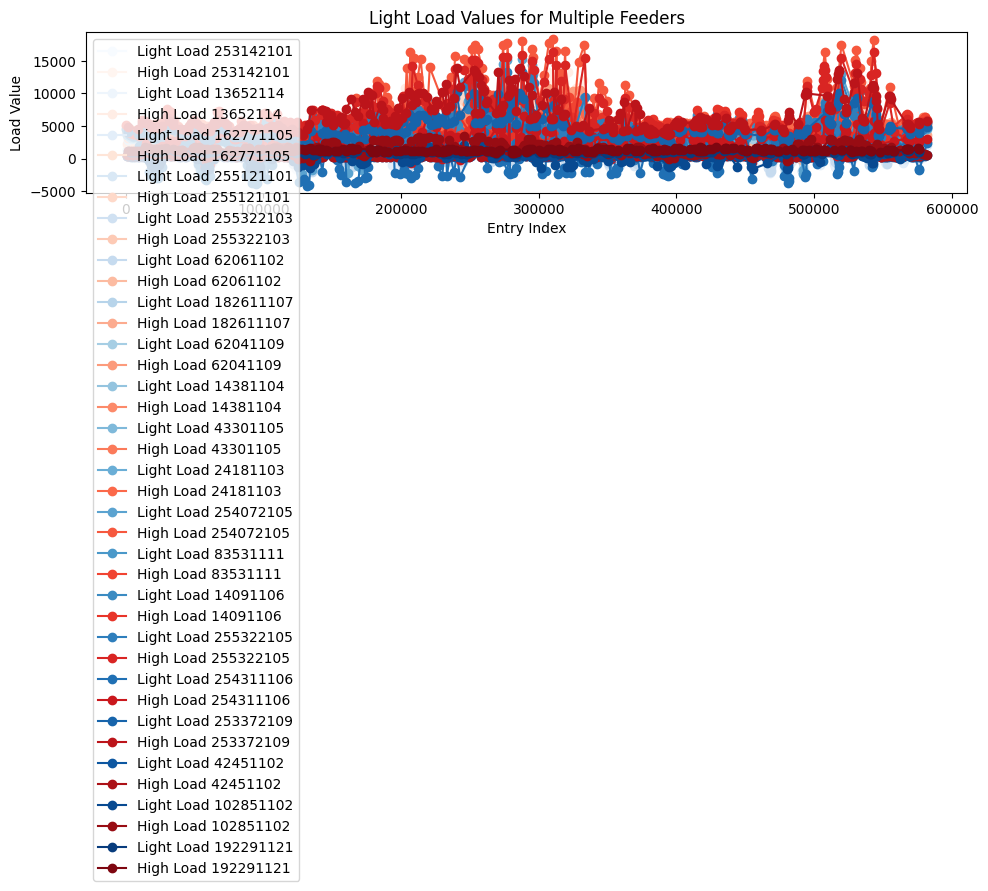

In [230]:
import matplotlib.pyplot as plt
import numpy as np

# Example list of FeederIDs you want to plot
feeder_ids = sample_data['FeederID'].unique()

# # Use the tab20 colormap
# colormap = plt.cm.get_cmap('tab20', num_feeders)
# colors = [colormap(i) for i in range(num_feeders)]

# Create a color map with enough colors for each FeederID
cmap_blues = plt.get_cmap('Blues')
colors_blues = [cmap_blues(i / len(feeder_ids)) for i in range(len(feeder_ids))]

cmap_reds = plt.get_cmap('Reds')
colors_reds = [cmap_reds(i / len(feeder_ids)) for i in range(len(feeder_ids))]

fig, ax = plt.subplots(figsize=(10, 6))

for feeder_id, color_blues, color_reds in zip(feeder_ids, colors_blues, colors_reds):
    specific_feeder_data = feeder_load[feeder_load['FeederID'] == feeder_id]
    print(specific_feeder_data.count())
    
    ax.plot(specific_feeder_data['Light'], label=f'Light Load {feeder_id}', color=color_blues, marker='o')
    ax.plot(specific_feeder_data['High'], label=f'High Load {feeder_id}', color=color_reds, marker='o')
    
ax.set_title('Light Load Values for Multiple Feeders')
ax.set_xlabel('Entry Index')
ax.set_ylabel('Load Value')

ax.legend()

plt.tight_layout()
plt.show()


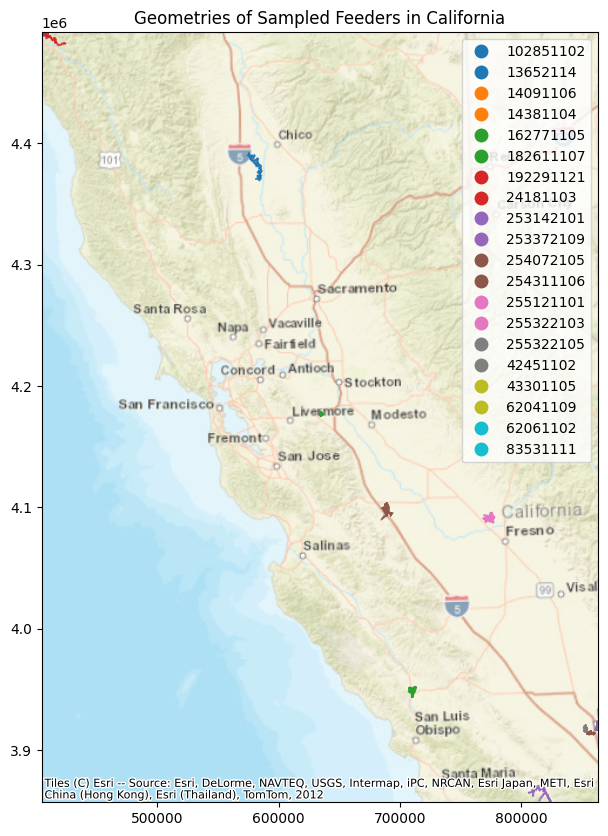

In [231]:
# Plot 2: Geometries of the sampled feeders on a map
gdf = gpd.GeoDataFrame(sample_data, geometry='geometry')
fig, ax = plt.subplots(figsize=(10, 10))

# Plot geometries with distinct colors
gdf.plot(ax=ax, column='FeederID', cmap='tab10', legend=True, legend_kwds={'bbox_to_anchor': (1, 1)})

# Set the extent of the map to the bounding box of all geometries with a buffer
buffer = 0.02  # You can adjust this value to add more or less padding
xmin, ymin, xmax, ymax = gdf.total_bounds
ax.set_xlim(xmin - buffer, xmax + buffer)
ax.set_ylim(ymin - buffer, ymax + buffer)

# Add basemap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.Esri.WorldStreetMap, alpha=0.8)
ax.set_title('Geometries of Sampled Feeders in California')
plt.show()

In [232]:
# print(sample_data[:1].geometry)
# print(sample_data[:1].geometry.centroid)
# print(sample_data[:1].geometry.centroid.x)
# print(sample_data[:1].geometry.centroid.y)
# print(sample_data.crs)


# from shapely.geometry import MultiLineString, Polygon

# def get_centroid_coordinates(geometry):
#     if isinstance(geometry, (MultiLineString, Polygon)) and geometry.is_valid:
#         centroid = geometry.centroid
#         return centroid.x, centroid.y
#     else:
#         raise ValueError("Invalid geometry type. Expected MultiLineString or Polygon.")

# multiline_centroid = get_centroid_coordinates(sample_data[:1].geometry)
# multiline_centroid

In [238]:
sample_data_gdf = gpd.GeoDataFrame(sample_data, geometry='geometry')

sample_data_gdf.crs

<Projected CRS: EPSG:26910>
Name: NAD83 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 126°W and 120°W - onshore and offshore. Canada - British Columbia; Northwest Territories; Yukon. United States (USA) - California; Oregon; Washington.
- bounds: (-126.0, 30.54, -119.99, 81.8)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

# feeder data:  582096
# sample:  100
# non-empty gdf:  FeederID     50
MonthHour    50
Light        50
High         50
geometry     50
dtype: int64


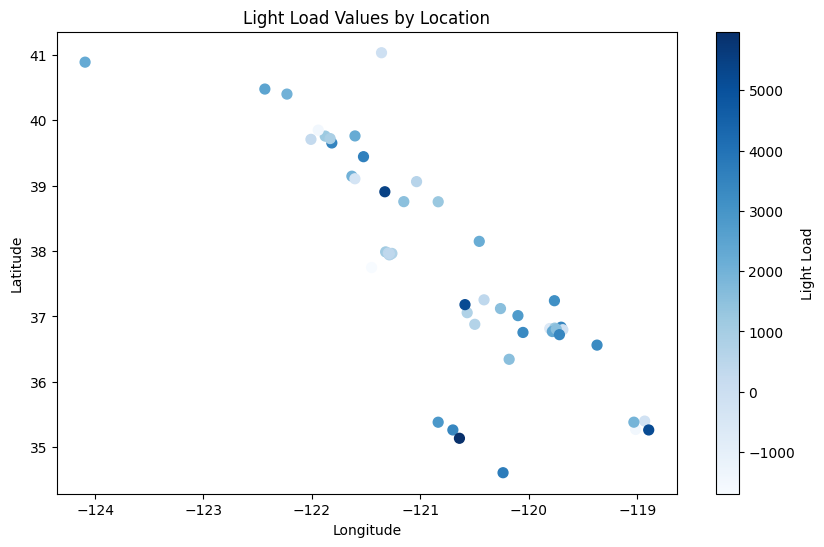

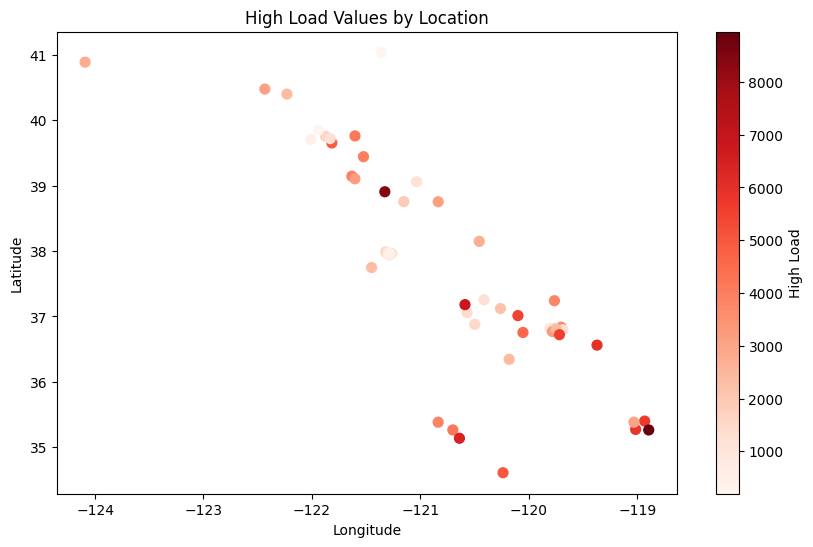

In [285]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

feeder_id_counts = feeder_load.groupby('FeederID').size()
duplicate_feeder_ids = feeder_id_counts[feeder_id_counts > 1].index
feeder_duplicates = feeder[feeder['FeederID'].isin(duplicate_feeder_ids)]
feeder_load_with_geometry = feeder_load.merge(feeder_duplicates[['FeederID', 'geometry']], on='FeederID', how='left')
duplicate_feeder_data_with_geometry = feeder_load_with_geometry[feeder_load_with_geometry['FeederID'].isin(duplicate_feeder_ids)]

print("# feeder data: ", duplicate_feeder_data_with_geometry['FeederID'].count())

sample_size = 100
sample_data = duplicate_feeder_data_with_geometry.sample(n=sample_size, random_state=50)

print("# sample: ", sample_data['FeederID'].count())

# Ensure that only rows with valid coordinates are plotted
sample_data_gdf = gpd.GeoDataFrame(sample_data, geometry='geometry')
sample_data_gdf = sample_data_gdf.dropna(subset=['geometry'])
print("# non-empty gdf: ", sample_data_gdf.count())

# Transform the CRS to WGS84 (EPSG:4326) if it is not already
if sample_data_gdf.crs != "EPSG:4326":
    sample_data_gdf = sample_data_gdf.to_crs("EPSG:4326")

# Extract the centroid coordinates for every entry
sample_data_gdf['longitude'] = sample_data_gdf.geometry.apply(lambda geom: geom.centroid.x if geom else None)
sample_data_gdf['latitude'] = sample_data_gdf.geometry.apply(lambda geom: geom.centroid.y if geom else None)

# Ensure that only rows with valid coordinates are plotted
# valid_coords = sample_data_gdf.dropna(subset=['longitude', 'latitude'])
# print("# valid coords: ", valid_coords.count())

# Plot Light Loads against longitude and latitude
fig, ax = plt.subplots(figsize=(10, 6))
sc = ax.scatter(sample_data_gdf['longitude'], sample_data_gdf['latitude'], c=sample_data_gdf['Light'], cmap='Blues', s=50)
plt.colorbar(sc, label='Light Load')
ax.set_title('Light Load Values by Location')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

# Plot High Loads against longitude and latitude
fig, ax = plt.subplots(figsize=(10, 6))
sc = ax.scatter(sample_data_gdf['longitude'], sample_data_gdf['latitude'], c=sample_data_gdf['High'], cmap='Reds', s=50)
plt.colorbar(sc, label='High Load')
ax.set_title('High Load Values by Location')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

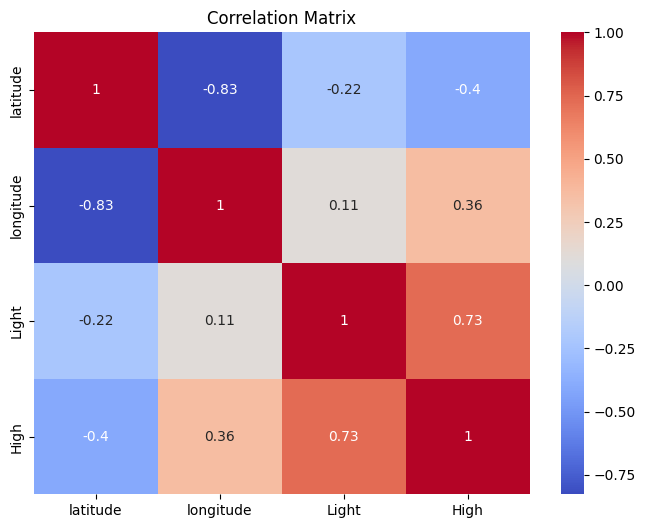

In [288]:
import seaborn as sns

# Compute the correlation matrix
corr_matrix = sample_data_gdf[['latitude', 'longitude', 'Light', 'High']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


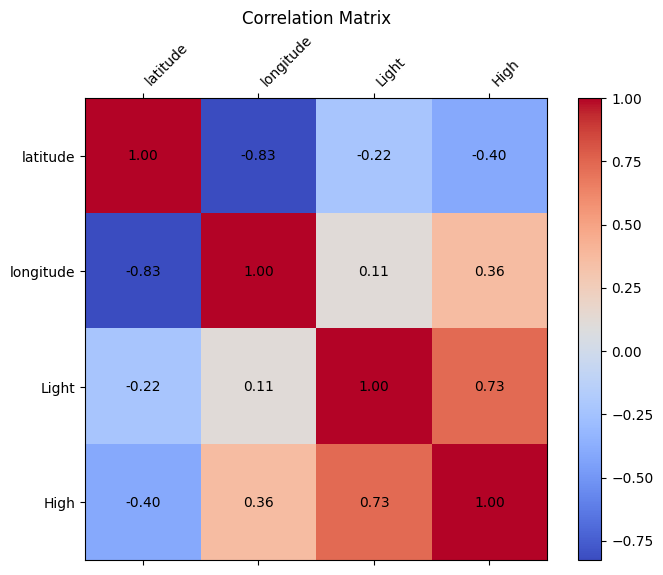

In [289]:
import matplotlib.pyplot as plt
import numpy as np

corr_matrix = sample_data_gdf[['latitude', 'longitude', 'Light', 'High']].corr()

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(corr_matrix, cmap='coolwarm')

fig.colorbar(cax)

ax.set_xticks(np.arange(len(corr_matrix.columns)))
ax.set_yticks(np.arange(len(corr_matrix.index)))
ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='left')
ax.set_yticklabels(corr_matrix.index)

for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.index)):
        ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')

plt.title('Correlation Matrix')
plt.show()


# feeder data:  582096
# sample:  100
# non-empty gdf:  FeederID     50
MonthHour    50
Light        50
High         50
TotalCust    50
geometry     50
dtype: int64


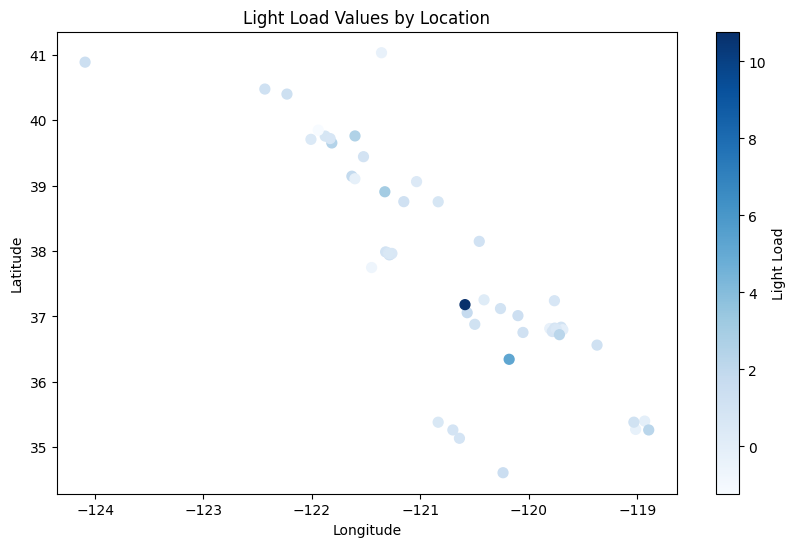

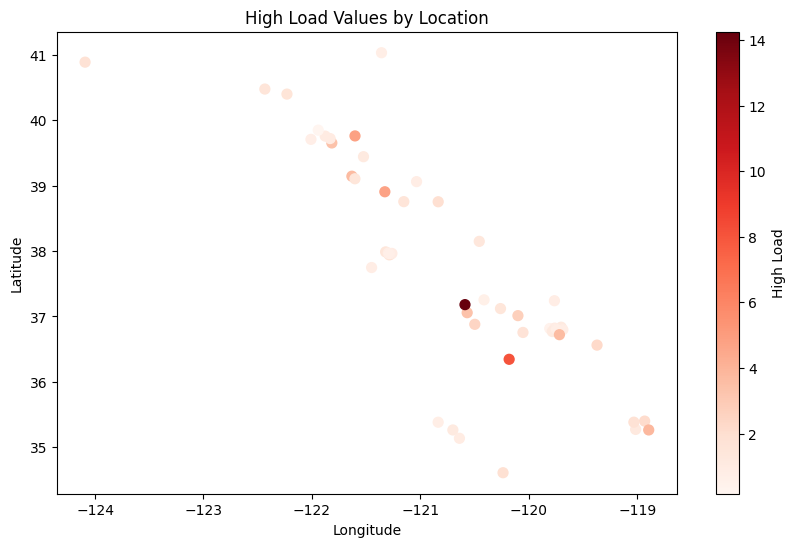

In [290]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Sum up the customer counts for each feeder
feeder['TotalCust'] = feeder[['ResCust', 'ComCust', 'IndCust', 'AgrCust', 'OthCust']].sum(axis=1)

# Merge the total customer counts into the feeder_load dataframe
feeder_load = feeder_load.merge(feeder[['FeederID', 'TotalCust']], on='FeederID', how='left')

# Normalize the Light and High values
feeder_load['Light'] = feeder_load['Light'] / feeder_load['TotalCust']
feeder_load['High'] = feeder_load['High'] / feeder_load['TotalCust']

# Continue with the rest of the original code
feeder_id_counts = feeder_load.groupby('FeederID').size()
duplicate_feeder_ids = feeder_id_counts[feeder_id_counts > 1].index
feeder_duplicates = feeder[feeder['FeederID'].isin(duplicate_feeder_ids)]
feeder_load_with_geometry = feeder_load.merge(feeder_duplicates[['FeederID', 'geometry']], on='FeederID', how='left')
duplicate_feeder_data_with_geometry = feeder_load_with_geometry[feeder_load_with_geometry['FeederID'].isin(duplicate_feeder_ids)]

print("# feeder data: ", duplicate_feeder_data_with_geometry['FeederID'].count())

sample_size = 100
sample_data = duplicate_feeder_data_with_geometry.sample(n=sample_size, random_state=50)

print("# sample: ", sample_data['FeederID'].count())

# Ensure that only rows with valid coordinates are plotted
sample_data_gdf = gpd.GeoDataFrame(sample_data, geometry='geometry')
sample_data_gdf = sample_data_gdf.dropna(subset=['geometry'])
print("# non-empty gdf: ", sample_data_gdf.count())

# Transform the CRS to WGS84 (EPSG:4326) if it is not already
if sample_data_gdf.crs != "EPSG:4326":
    sample_data_gdf = sample_data_gdf.to_crs("EPSG:4326")

# Extract the centroid coordinates for every entry
sample_data_gdf['longitude'] = sample_data_gdf.geometry.apply(lambda geom: geom.centroid.x if geom else None)
sample_data_gdf['latitude'] = sample_data_gdf.geometry.apply(lambda geom: geom.centroid.y if geom else None)

# Ensure that only rows with valid coordinates are plotted
# valid_coords = sample_data_gdf.dropna(subset(['longitude', 'latitude']))
# print("# valid coords: ", valid_coords.count())

# Plot Light Loads against longitude and latitude
fig, ax = plt.subplots(figsize=(10, 6))
sc = ax.scatter(sample_data_gdf['longitude'], sample_data_gdf['latitude'], c=sample_data_gdf['Light'], cmap='Blues', s=50)
plt.colorbar(sc, label='Light Load')
ax.set_title('Light Load Values by Location')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

# Plot High Loads against longitude and latitude
fig, ax = plt.subplots(figsize=(10, 6))
sc = ax.scatter(sample_data_gdf['longitude'], sample_data_gdf['latitude'], c=sample_data_gdf['High'], cmap='Reds', s=50)
plt.colorbar(sc, label='High Load')
ax.set_title('High Load Values by Location')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()


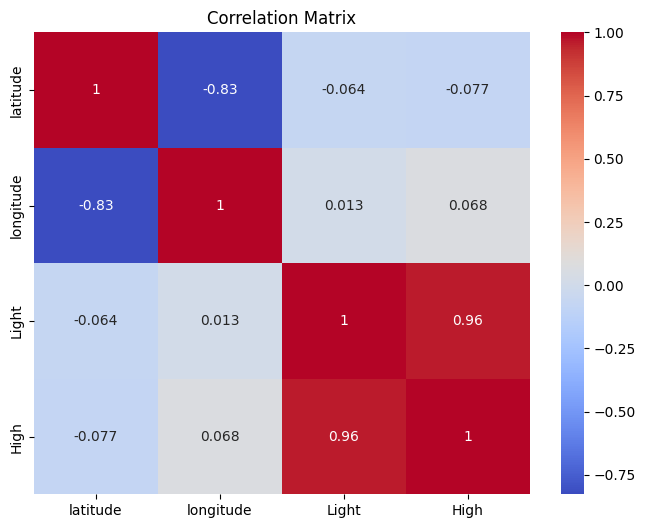

In [291]:
import seaborn as sns

# Compute the correlation matrix
corr_matrix = sample_data_gdf[['latitude', 'longitude', 'Light', 'High']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Therefore, there is almost no correlation between spatial location of feeder (lat, long coordinates) and its feeder load profile!


# Therefore, there is almost no correlation between spatial location of feeder (lat, long coordinates) and its feeder load profile!